# Imports

In [1]:
from tensorflow import keras
from models.ts_cnn import MULTI_TS_CNN as ts_cnn
import numpy as np
from sklearn.model_selection import train_test_split
from models.loader import loader
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils.normalisation import min_max

In [2]:
# Reading Data
x_positive_acc = np.loadtxt('data/binary_training_set/incidents_acc.txt')
x_positive_gyro = np.loadtxt('data/binary_training_set/incidents_gyro.txt')
x_negative_acc = np.loadtxt('data/binary_training_set/no_incidents_acc.txt')
x_negative_gyro = np.loadtxt('data/binary_training_set/no_incidents_gyro.txt')
# x_negative = preprocessing.normalize(x_negative)

x_noise_acc = np.random.rand(200, 200)
x_noise_gyro = np.random.rand(200, 200)

# Stacking
x_positive = np.stack([x_positive_acc, x_positive_gyro], axis=1)
x_negative = np.stack([x_negative_acc, x_negative_gyro], axis=1)

x_noise = np.stack([x_noise_acc, x_noise_gyro], axis=1)
x_negative = np.concatenate([x_noise, x_negative])


# Labels
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])


print(f'x positive: {x_positive.shape}')
print(f'x negative: {x_negative.shape}')
print(f'y positive: {y_positive.shape}')
print(f'y negative: {y_negative.shape}')

x positive: (780, 2, 200)
x negative: (700, 2, 200)
y positive: (780,)
y negative: (700,)


In [3]:
scaler = preprocessing.StandardScaler()
x = np.concatenate([x_positive, x_negative], axis=0)

x_acc_norm = []
x_gyro_norm = []
for i in range(x.shape[0]): 
    try:
        x_acc_norm.append(x[i][0]) #(min_max(x[i][0].tolist())) # Add if you need normalisation
        x_gyro_norm.append(x[i][0]) #(min_max(x[i][1].tolist())) # Add if you need normalisation
    except:
        continue

x = np.stack([np.asarray(x_acc_norm), np.asarray(x_gyro_norm)], axis=1)
x_acc = np.asarray(x_acc_norm)
x_gyro = np.asarray(x_gyro_norm)

y = np.concatenate([y_positive, y_negative], axis=0)

print(f'x_acc: {x_acc.shape}')
print(f'x_gyro: {x_gyro.shape}')
print(f'y: {y.shape}')



x_acc: (1480, 200)
x_gyro: (1480, 200)
y: (1480,)


In [4]:
y = y.reshape(len(y), 1)
y = keras.utils.to_categorical(y)

print(f'x: {x.shape}')
print(f'nans: {np.any(np.isnan(x))}')
print(f'y: {y.shape}')

# if np.any(np.isnan(x_acc)): # This might produce a bug
#     # to fix the bug
#     print('NANs found')
#     idx = ~np.isnan(x).any(axis=1) # find the nans if any
#     x = x[idx]
#     y = y[idx]
#     print(f'x: {x.shape}')
#     print(f'y: {y.shape}')


x: (1480, 2, 200)
nans: False
y: (1480, 2)


In [5]:
model = ts_cnn()

idx = np.random.permutation(len(x))
x_acc = x_acc[idx]
x_gyro = x_gyro[idx]
y = y[idx]

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
                loss=['binary_crossentropy'],
                metrics=['accuracy'])


In [11]:
epochs = 500
batch_size = 64
model.fit(
    [x_acc, x_gyro],
    y,
    batch_size=batch_size,
    epochs=epochs,
    # callbacks=callbacks,
    validation_split=0.4,
    verbose=2,
)
history = model.history.history

Epoch 1/500
14/14 - 8s - loss: 0.8631 - accuracy: 0.3041 - val_loss: 0.8919 - val_accuracy: 0.1689 - 8s/epoch - 573ms/step
Epoch 2/500
14/14 - 0s - loss: 0.8174 - accuracy: 0.5079 - val_loss: 0.7748 - val_accuracy: 0.1486 - 266ms/epoch - 19ms/step
Epoch 3/500
14/14 - 0s - loss: 0.7756 - accuracy: 0.5068 - val_loss: 0.7167 - val_accuracy: 0.4324 - 262ms/epoch - 19ms/step
Epoch 4/500
14/14 - 0s - loss: 0.7388 - accuracy: 0.5068 - val_loss: 0.6783 - val_accuracy: 0.8311 - 266ms/epoch - 19ms/step
Epoch 5/500
14/14 - 0s - loss: 0.7068 - accuracy: 0.5101 - val_loss: 0.6492 - val_accuracy: 0.8378 - 258ms/epoch - 18ms/step
Epoch 6/500
14/14 - 0s - loss: 0.6784 - accuracy: 0.5495 - val_loss: 0.6265 - val_accuracy: 0.8412 - 265ms/epoch - 19ms/step
Epoch 7/500
14/14 - 0s - loss: 0.6532 - accuracy: 0.6486 - val_loss: 0.6079 - val_accuracy: 0.8361 - 276ms/epoch - 20ms/step
Epoch 8/500
14/14 - 0s - loss: 0.6328 - accuracy: 0.7061 - val_loss: 0.5913 - val_accuracy: 0.8328 - 284ms/epoch - 20ms/step
Ep

In [12]:
# Saving current model
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('multi_model_2022-10-26.tflite', 'wb') as f:
    f.write(tflite_model)


# save model weights
model.save_weights("multi_model_2022-10-26.h5")

INFO:tensorflow:Assets written to: C:\Users\joonn\AppData\Local\Temp\tmpm4_sgdya\assets


INFO:tensorflow:Assets written to: C:\Users\joonn\AppData\Local\Temp\tmpm4_sgdya\assets


# Training Results

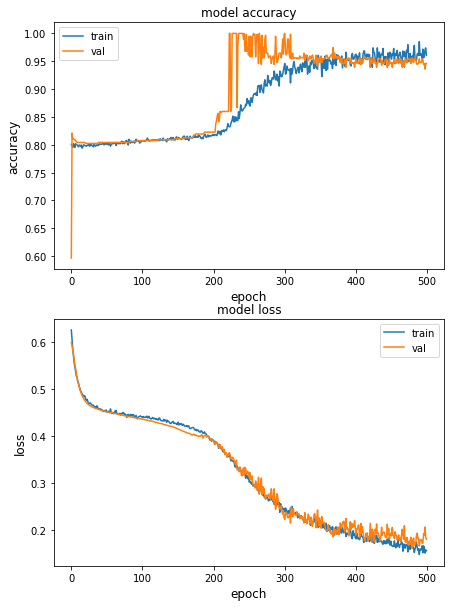

In [12]:
plt.figure(figsize=(7, 10))
metric = "accuracy"
plt.subplot(2, 1, 1)
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")

plt.subplot(2, 1, 2)
metric = "loss"
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

## Discussion:

Currently the sweet spot for training the algorithm is as follows, considering current 97% of accuracy. 

- epochs = 200
- batch_size = 64
- learning_rate = 0.00003


This can indicate that introducing the gyroscope as a second input, we can improve the overall accuracy of the model slightly.

# Validations

Todo: 

- [x] Generate new data
- [x] Load the current algorithm (multi-input)
- [ ] Load the data wihtin this notebook
- [ ] Extract the data from the previous testing at Keppel
- [ ] Use the valudation data as input

In [ ]:
# Data Loader 
# ...

In [7]:
# Model Loader:

model = ts_cnn()
# model.load_weights('multi_model_weights_97.h5')
model.load_weights('multi_model_2022-10-26.h5')

In [8]:
idx = np.random.permutation(len(x))
x_acc = x_acc[idx]
x_gyro = x_gyro[idx]
y = y[idx]

print(y[:5]) # see a couple of examples
np.argmax(y, axis=1)[:5]  

# find how many positive and negative samples are in the dataset
print(f'positive: {np.sum(np.argmax(y, axis=1) == 0)}')
print(f'negative: {np.sum(np.argmax(y, axis=1) == 1)}')

# y_val = np.reshape(y, (len(y),))
y_val = y.argmax(axis=1)
y_pred = np.argmax(model.predict([x_acc, x_gyro]), axis=1)

# find how many positive and negative samples are in the predicted dataset
print(f'prediction_positive: {np.sum(y_pred == 0)}')
print(f'prediction_negative: {np.sum(y_pred == 1)}')

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
positive: 700
negative: 780
47/47 [==============================] - 6s 5ms/step
prediction_positive: 752
prediction_negative: 728


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred, labels=[0,1])

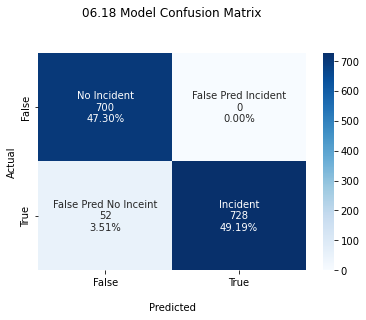

In [10]:
# Matrix with labels
group_names = ['No Incident','False Pred Incident','False Pred No Inceint','Incident']
group_counts = ["{0:0.0f}".format(value) for value in result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in result.flatten()/np.sum(result)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(result, annot=labels, fmt='', cmap='Blues')
ax.set_title('06.18 Model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()